In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.8.2 anndata==0.7.5 umap==0.4.6 numpy==1.21.5 scipy==1.5.4 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.1 python-igraph==0.8.3


In [2]:
# scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0

In [3]:
# import local module to load files in a directory and store as anndata object
import sys
sys.path.insert(0, '/scratchfs/cherring/brain_maturation/')
import h5_samples as dta 

In [4]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.7.6) on 2022-03-28 11:58.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [5]:
stage_order = ['Fetal', 'Neonatal', 'Infancy', 'Childhood', 'Adolescence', 'Adult']
age_order = ['ga22', 'ga24', 'ga34', '2d', '34d', '86d',
             '118d', '179d', '301d', '1yr', '2yr', '3yr', '4yr',
             '6yr',  '8yr',  '10yr', '12yr','14yr','16yr','17yr', 
             '20yr', '25yr', '40yr'] 
batch_order = ['RL2103_ga22_v3', 'RL2107_ga24_v3', 'RL2121_ga34_v3',
               'RL1777_2d_v3', 'RL1612_34d_v2', 'RL2100_86d_v3',
               'RL2104_118d_v3', 'RL2108_179d_v3', 'RL2122_301d_v3',
               'RL2125_1yr_v3', 'RL2105_1yr_v3', 'RL1786_2yr_v3', 'RL1613_2yr_v2',
               'RL2129_3yr_v3', 'RL2109_4yr_v3', 'RL2106_6yr_v3', 'RL1614_8yr_v2',
               'RL2110_10yr_v3', 'RL2126_10yr_v3', 'RL2127_12yr_v3',
               'RL2130_14yr_v3', 'RL2102_16yr_v3', 'RL2131_17yr_v3',
               'RL2123_20yr_v3', 'RL2128_20yr_v3', 'RL2132_25yr_v3',
               'RL2124_40yr_v3']

### Read in loom adata and select for GABA neurons

In [6]:
loom_file_nm = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/data/2020-09-09_whole-tissue_with-looms.h5ad"
adata = sc.read( loom_file_nm)

### Read in GABA cluster adata

In [7]:
gaba_file_nm = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/data/2020-12-18_whole-tissue_post-clustering.h5ad"
gaba = sc.read( gaba_file_nm)
gaba = gaba[gaba.obs['major_clust']!='Poor-Quality']

Trying to set attribute `.uns` of view, copying.


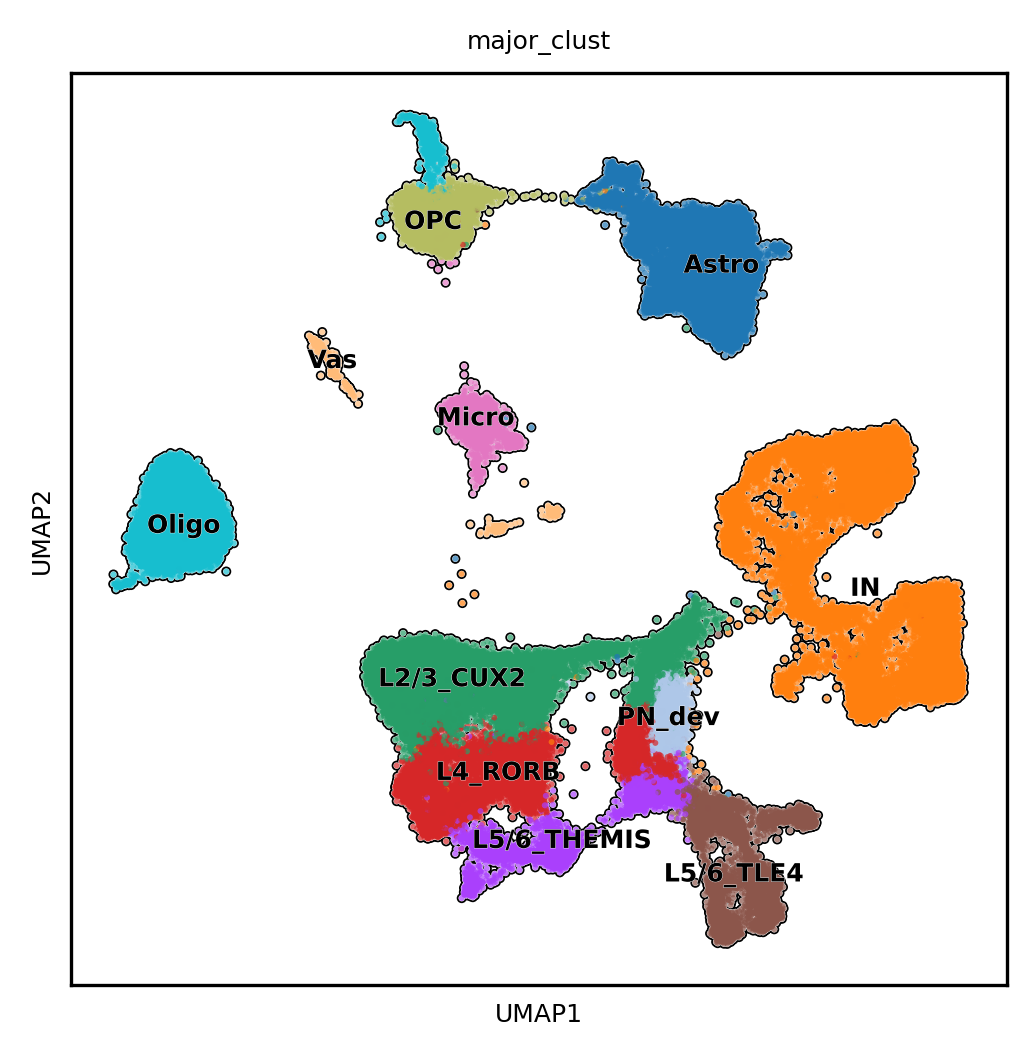

In [8]:
sc.settings.set_figure_params( dpi=150, fontsize=6)
sc.pl.embedding( gaba, basis='umap', color=['major_clust'], legend_fontsize=6, add_outline=True, legend_loc='on data', size=8, legend_fontoutline=0.2)

### Find intersect of barcodes and match order of gaba to loom

In [9]:
# adatas do not contain same nucs, so need to take intersect of barcodes (BCs) 
all_loom_mk  = dta.member_test( adata.obs_names.values, gaba.obs_names.values)
pre_adata_mk = dta.member_test( gaba.obs_names.values,  adata.obs_names.values)
adata = adata[all_loom_mk]
gaba = gaba[pre_adata_mk]
adata.shape, gaba.shape

((121202, 26747), (121202, 26747))

In [10]:
# need to match order of BCs to make sure (un)spliced cts get assigned to correct nucs
adata_bc_list = adata.obs_names.values.tolist()
gaba_bc_list  = gaba.obs_names.values.tolist()
# return adata args in loom BC order 
pre_to_loom_args = np.array([gaba_bc_list.index(ii) for ii in adata_bc_list])
gaba = gaba[pre_to_loom_args]

In [11]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=gaba.obs_names.values).sum()

0

In [12]:
# adatas do not contain same nucs, so need to take intersect of barcodes (BCs) 
all_loom_mk2  = dta.member_test( adata.var_names.values, gaba.var_names.values)
pre_adata_mk2 = dta.member_test( gaba.var_names.values,  adata.var_names.values)
adata = adata[:,all_loom_mk2]
gaba = gaba[:,pre_adata_mk2]
adata.shape, gaba.shape

((121202, 26747), (121202, 26747))

In [13]:
# need to match order of vars to make sure (un)spliced cts get assigned to correct nucs
adata_var_list = adata.var_names.values.tolist()
gaba_var_list  = gaba.var_names.values.tolist()
# return adata args in loom var order 
pre_to_loom_args2 = np.array([gaba_var_list.index(ii) for ii in adata_var_list])
gaba = gaba[:,pre_to_loom_args2]

In [14]:
# check if order of genes match, should sum to 0
(adata.var_names.values!=gaba.var_names.values).sum()

0

In [15]:
adata.shape, gaba.shape

((121202, 26747), (121202, 26747))

In [16]:
adata.obsm = gaba.obsm.copy()
# adata.obs['leiden'] = gaba.obs['leiden']
adata.obs['sub_clust'] = gaba.obs['sub_clust']
adata.obs['major_clust'] = gaba.obs['major_clust']
adata.obs['stage_ids'] = gaba.obs['stage_ids']
adata.X = gaba.X

In [17]:
# clust_oi = ['MGE_dev', 'CGE_dev', 'ID2', 'PV']
# adata = adata[adata.obs['major_clust'].isin(clust_oi)]

# change names to match manuscript
# adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)
# adata.obs.loc[adata.obs['sub_clust']=='LAMP5_CA1','sub_clust']  = 'LAMP5_NOS1'
# adata.obs.loc[adata.obs['sub_clust']=='LAMP5_LCP2','sub_clust'] = 'LAMP5_CCK'
# adata.obs.loc[adata.obs['sub_clust']=='LAMP5_NMBR','sub_clust'] = 'LAMP5_NDNF'

In [18]:
# hvg_th = 4_000
# sc.pp.highly_variable_genes( adata, n_top_genes=hvg_th, n_bins=20, flavor='seurat', inplace=True)
# high_adata = adata[:,adata.var.highly_variable.values]
# high_adata.shape

In [19]:
# n_comps = 350
# sc.pp.pca( high_adata, n_comps=n_comps)
# pca = high_adata.obsm['X_pca']

In [20]:
pcs = 365 #(np.cumsum( high_adata.uns['pca']['variance_ratio'])<0.50).sum()
# if( pcs==n_comps):
#     pcs = None
#     print( "re-run PCA with more components")
# pcs

In [21]:
# high_adata = dta.umat( stage_order, high_adata, n_neighbors=25, n_pcs=pcs, rand=123456) #123, #12 #12345 #123456

In [22]:
# sc.pp.neighbors( high_adata, n_neighbors=25, n_pcs=pcs, random_state=6)
# sc.tl.umap( high_adata, random_state=6)

## Format clusters and colors to match manuscript

In [23]:
color_dict = {'CCK_RELN':'#a8484d','CCK_SORCS1':'#18f3f0','CCK_SYT6':'#fffe03','CGE_dev':'#cd7c0a','ID2_CSMD1':'#17a715','ID2_dev':'#4c12e3',
              'LAMP5_NOS1':'#b2e993','LAMP5_CCK':'#ee0aad','LAMP5_NDNF':'#050156','MGE_dev':'#fefec0','PV_SCUBE3':'#3efb5c','PV_SST':'#6f0607',
              'PV_SULF1':'#6cadcb','PV_WFDC2':'#fb1916','PV_dev':'#f2ad5d','SST_ADGRG6':'#91c827','SST_B3GAT2':'#a84afa','SST_BRINP3':'#f995ef',
              'SST_CALB1':'#cc709b','SST_NPY':'#588064','SST_STK32A':'#703192','SST_TH':'#3a4725','VIP_ABI3BP':'#0b76a5','VIP_ADAMTSL1':'#93e3ff',
              'VIP_CHRM2':'#3b80fe','VIP_CRH':'#2ebb8e','VIP_DPP6':'#0a3ef2','VIP_HS3ST3A1':'#fd4a77','VIP_KIRREL3':'#d1ec39','VIP_PCDH20':'#5fed05',
              'VIP_dev':'#9c9b7d','the_rest': '#b0afae'}

In [24]:
adata.obs['plot'] = adata.obs['sub_clust'].astype(str)
# adata.obs['plot'].loc[~adata.obs['sub_clust'].isin( ['MGE_dev','CGE_dev','ID2_dev','LAMP5_NOS1','LAMP5_CCK'])] = 'the_rest'
adata.obs['plot'].loc[:] = 'the_rest'
adata.obs['plot'].value_counts()

the_rest    121202
Name: plot, dtype: int64

In [25]:
adata.uns['arcsinh_cofact'] = 0.55
adata.obs['arcsinh_num_ages'] = np.arcsinh( adata.obs['numerical_ages'].values / adata.uns['arcsinh_cofact'])

In [26]:
for itr, s_itr in enumerate( stage_order):
    adata.obs.loc[adata.obs['stage_ids']==s_itr,'stage_num'] = itr
adata.obs['numerical_ages'] = adata.obs['numerical_ages'].astype(float)
adata.obs['stage_num'] = adata.obs['stage_num'].astype(float)
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)

# adata.obs.loc[adata.obs['sub_clust']=='ID2_dev','sub_clust'] = 'CGE_dev'
# adata.obs.loc[adata.obs['sub_clust'].isin(['MGE_dev-1','MGE_dev-2']),'sub_clust'] = 'MGE_dev'

### Import umap to match manuscript

In [27]:
# umap_ad = sc.read_h5ad( "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/data/2020-12-18_whole-tissue_post-clustering.h5ad")

In [28]:
# # need to match order of BCs to make sure (un)spliced cts get assigned to correct nucs
# adata_bc_list = adata.obs_names.values.tolist()
# umap_bc_list  = gaba.obs_names.values.tolist()
# # return adata args in loom BC order 
# pre_to_loom_args = np.array([umap_bc_list.index(ii) for ii in adata_bc_list])
# umap_ad = umap_ad[pre_to_loom_args]

# adata.obsm['X_umap'] = umap_ad.obsm['X_umap']

... storing 'sub_clust' as categorical
... storing 'plot' as categorical


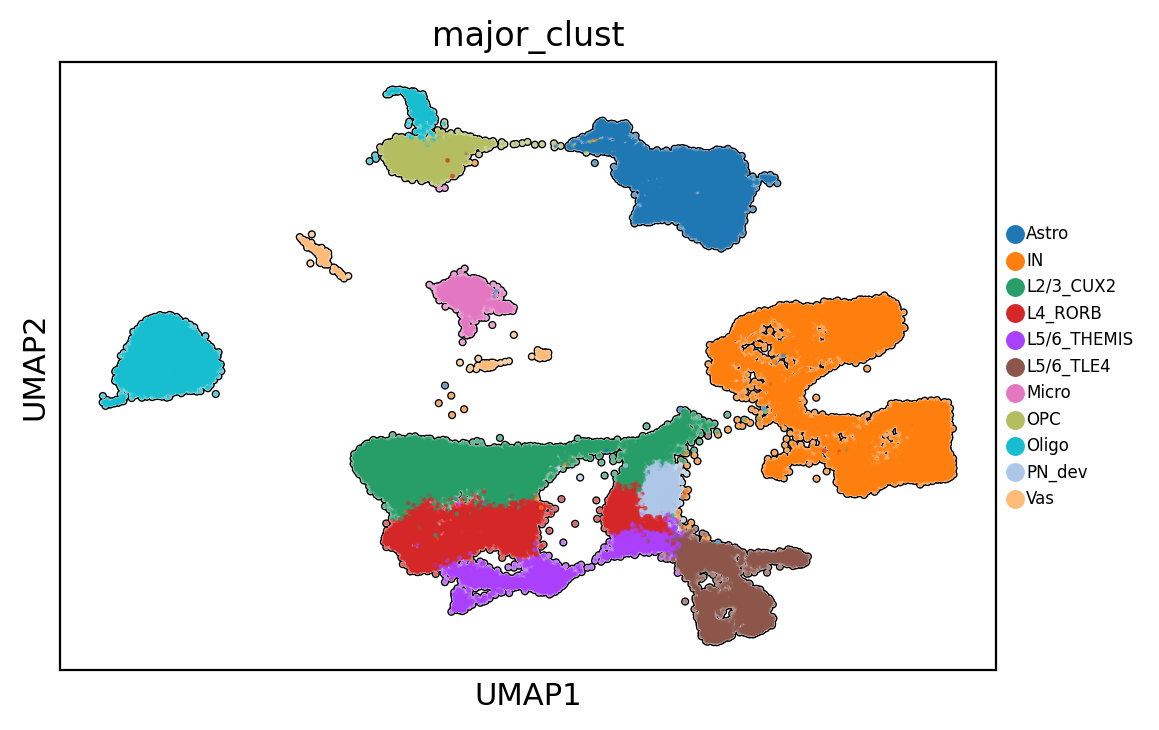

In [29]:
scv.set_figure_params('scvelo')
sc.pl.embedding( adata, basis='umap', color=['major_clust'], legend_fontsize=6, add_outline=True, 
                 size=12, legend_fontoutline=0.2)#, palette=color_dict)

## Compute cytotrace and connectivity kernels before scVelo operations

In [30]:
def plot_kernel( adata):
    scv.pl.velocity_embedding_stream( adata, color="lightgrey", vkey="T_fwd", basis="umap", 
                                      legend_loc='none', figsize=(8,8), cmap='viridis',
                                      linewidth=4.0, arrow_style='->')
#                                   groups=['CGE_dev','MGE_dev','LAMP5_NOS1','LAMP5_CCK','ID2_dev'],
    return

In [31]:
# CytoTRACE by default uses imputed data - a simple way to compute KNN-imputed data is to use scVelo's moments
# function. However, note that this function expects `spliced` counts because it's designed for RNA velocity,
# so we're using a simple hack here:
# if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
adata.layers['loom_spliced'] = adata.layers['spliced'].copy()
adata.layers['loom_unspliced'] = adata.layers['unspliced'].copy()

adata.layers['spliced'] = adata.X.copy()
adata.layers['unspliced'] = adata.X.copy()

# scv.pp.neighbors( adata, n_neighbors=25, n_pcs=pcs)
# compute KNN-imputation using scVelo's moments function
scv.pp.moments( adata, n_pcs=pcs, n_neighbors=25)

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel( adata)
ctk.compute_transition_matrix( threshold_scheme="soft", nu=0.5, n_jobs=20)

adata.layers['spliced'] = adata.layers['loom_spliced']
adata.layers['unspliced'] = adata.layers['loom_unspliced']

computing neighbors
    finished (0:02:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:02:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


  0%|          | 0/121202 [00:00<?, ?cell/s]

In [32]:
ctk.compute_projection( basis="umap")

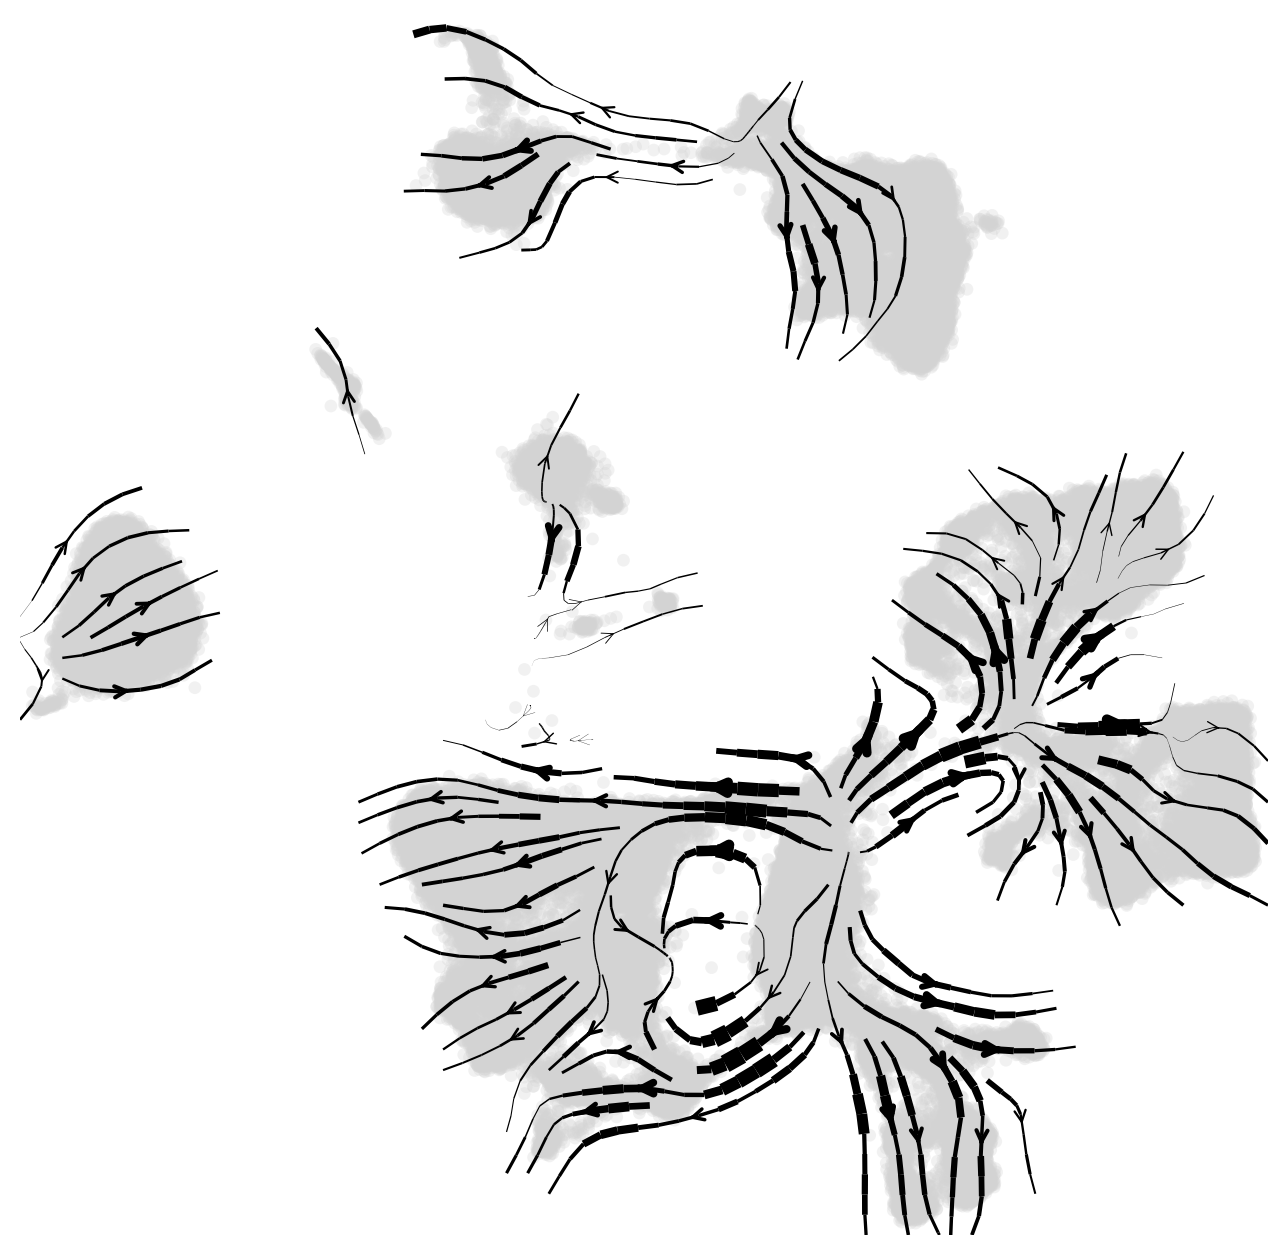

In [33]:
plot_kernel( adata)

In [34]:
adata = adata[:,adata.var['highly_variable']].copy()

In [44]:
from cellrank.tl.kernels import ConnectivityKernel
cnk = ConnectivityKernel( adata)#.compute_transition_matrix( density_normalize=False)
cnk.compute_transition_matrix( density_normalize=True)
cnk.compute_projection( basis="umap")

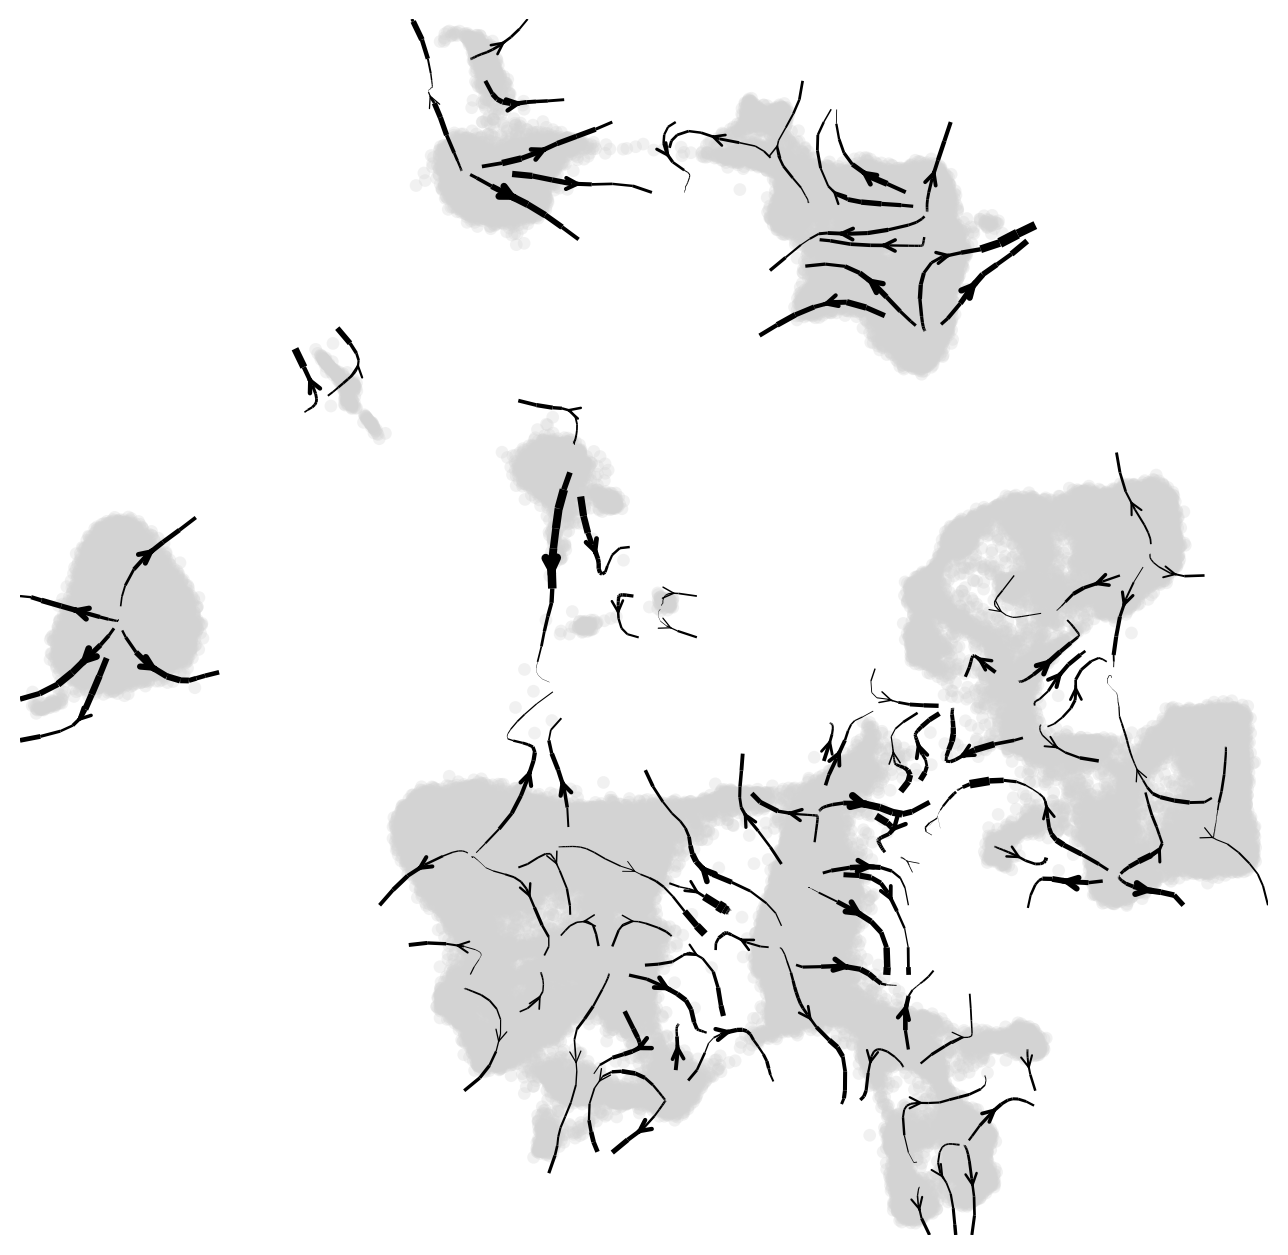

In [45]:
plot_kernel( adata)

## Combine CytoTRACE and connectivity kernels

In [46]:
combined_kernel = 0.50*cnk + 0.50*ctk
combined_kernel.compute_transition_matrix()
combined_kernel.compute_projection( basis="umap")

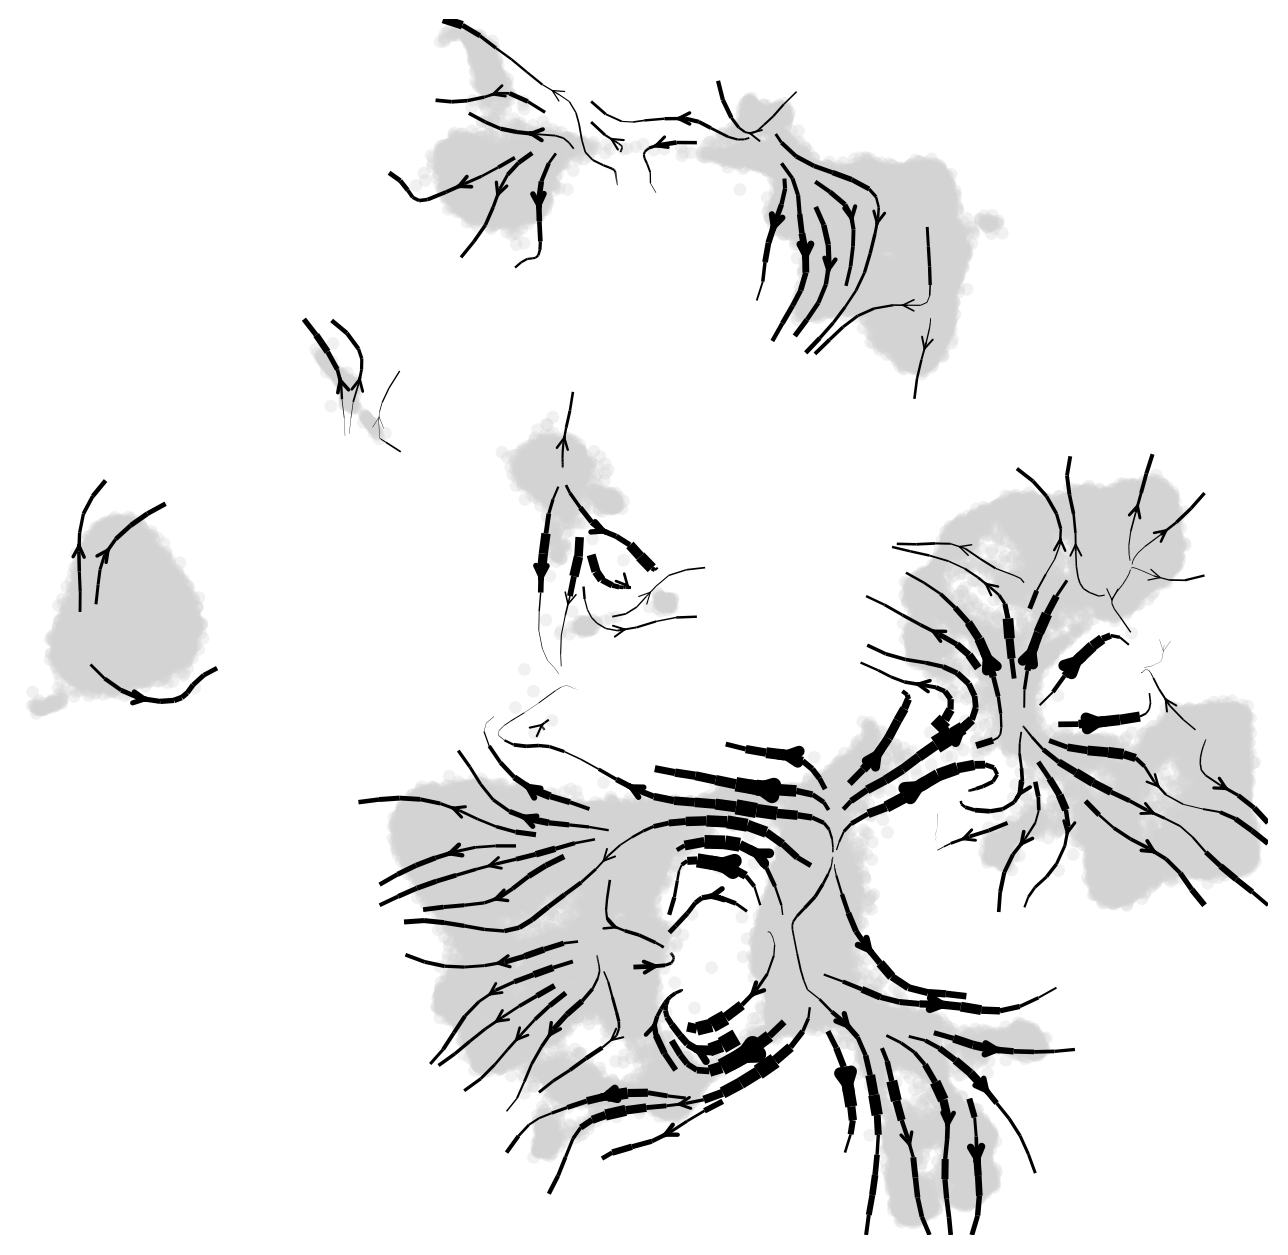

In [47]:
plot_kernel( adata)

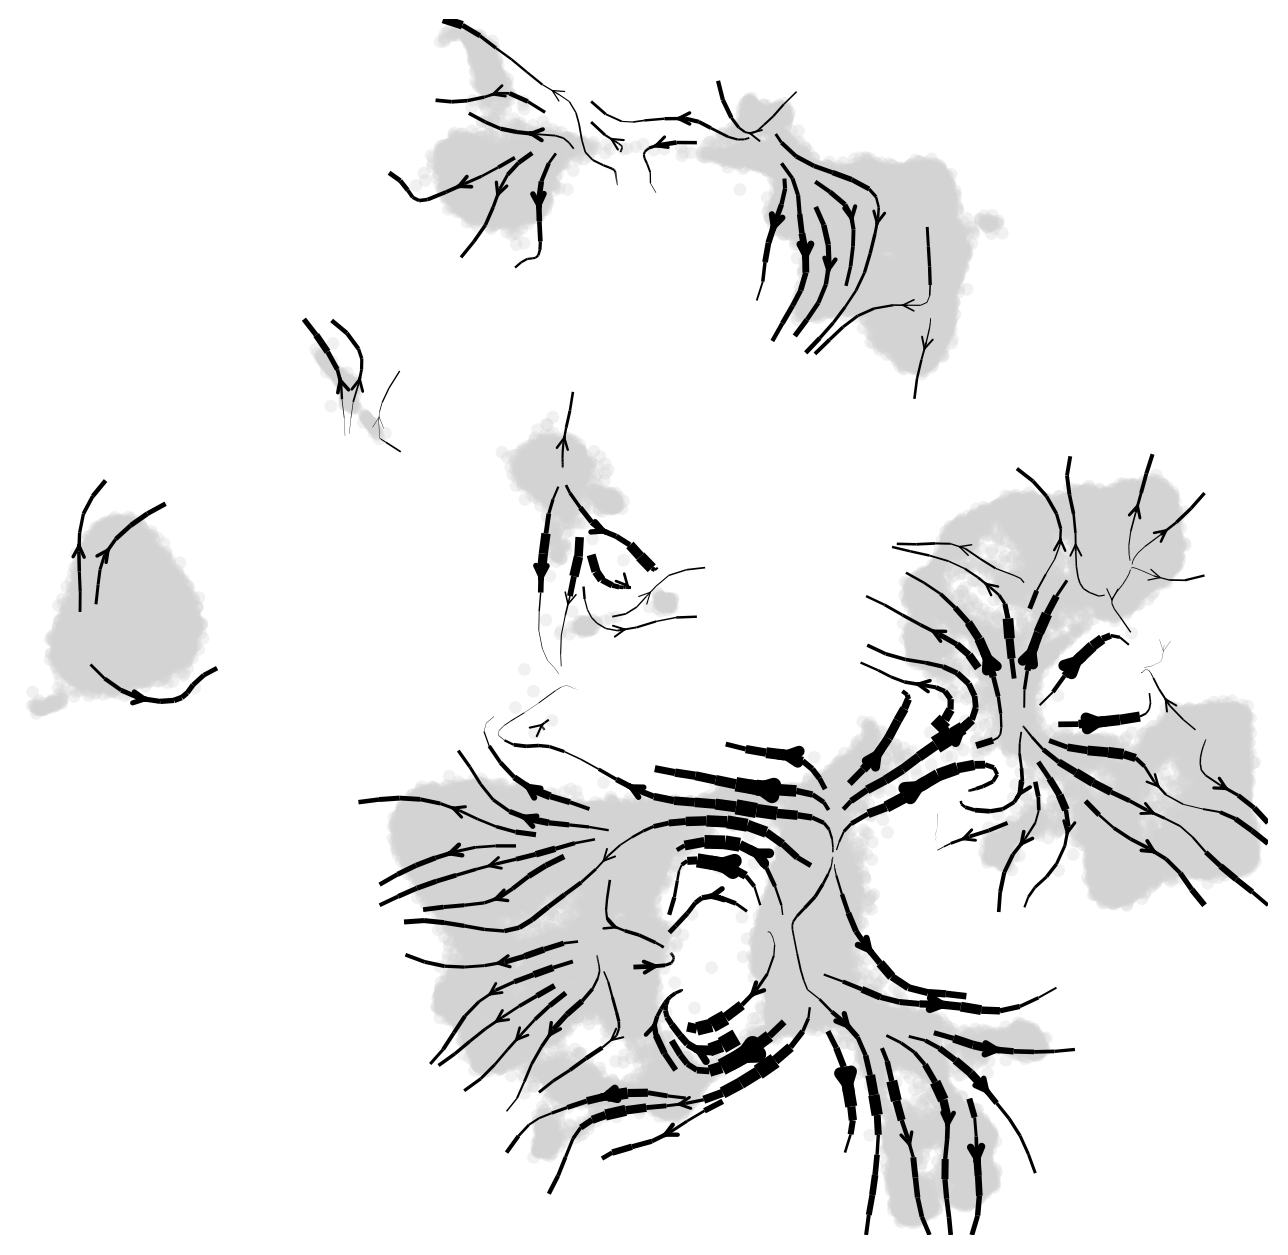

In [39]:
plot_kernel( adata)

### Waddington-OT

In [36]:
# for itr, s_itr in enumerate( stage_order):
#     adata.obs.loc[adata.obs['stage_ids']==s_itr,'stage_num'] = itr
    
# adata.obs['numerical_ages'] = adata.obs['numerical_ages'].astype(float)
# adata.obs['stage_num'] = adata.obs['stage_num'].astype(float)
# # adata.obs['numerical_ages'].unique()

In [37]:
# from cellrank.external.kernels import WOTKernel
# wk = WOTKernel( adata, time_key="stage_num", compute_cond_num=False)

In [38]:
# wk.compute_initial_growth_rates( organism="human", key_added="growth_rate_init")
# scv.pl.scatter( adata, c="growth_rate_init", legend_loc="right", basis="umat", s=10)

In [39]:
# adata.obs['numerical_ages'] = adata.obs['numerical_ages'].astype(float)
# adata.obs['stage_num'] = adata.obs['stage_num'].astype(float)

# wk.compute_transition_matrix( growth_iters=5, growth_rate_key="stage_num", last_time_point="connectivities")

In [40]:
# ax = wk.plot_single_flow(
#     cluster_key="sub_clust",
#     time_key="stage_num",
#     cluster="MGE_dev",
#     min_flow=0.1,
#     xticks_step_size=1,
#     show=False,
#     dpi=100,
#     clusters=["LAMP5_NOS1", "LAMP5_CCK"],
# )

# # prettify the plot a bit, rotate x-axis tick labels
# locs, labels = plt.xticks()
# ax.set_xticks(locs)
# ax.set_xticklabels(stage_order, rotation=90)

## Pre-process layers data

In [41]:
scv.settings.verbosity = 3
scv.set_figure_params('scvelo')  # for beautified visualization

In [42]:
scv.pp.filter_and_normalize( adata, min_shared_counts=5, n_top_genes=1500)

Filtered out 9266 genes that are detected 5 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 1500 highly variable genes.


In [43]:
adata.shape, adata.layers['spliced'].shape

((121202, 1500), (121202, 1500))

Recomputing nearest neighbors, with higher number of neighbors, from 15 to 30. Not enough detail in some portions of map

In [44]:
def plot_vel( nn, adata=adata, n_pcs=pcs, mode='deterministic', basis='umap', cc=['major_clust']):
#     scv.pp.moments( adata, n_pcs=n_pcs, n_neighbors=25)
    scv.pp.neighbors( adata, n_neighbors=nn, n_pcs=n_pcs)
    adata.layers['Ms'] = scv.utils.get_moments( adata, layer='spliced')
    adata.layers['Mu'] = scv.utils.get_moments( adata, layer='unspliced')
    scv.tl.velocity( adata, mode=mode)
    scv.tl.velocity_graph( adata)
    scv.pl.velocity_embedding_stream( adata, basis=basis, color=cc, figsize=(8,8))
    return

## Stochastic

computing neighbors
    finished (0:03:52) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:49) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/121202 [00:00<?, ?cells/s]

/scratchfs/cherring/brain_maturation/bm_project_env/hotspot_env/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (1:14:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:01:13) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


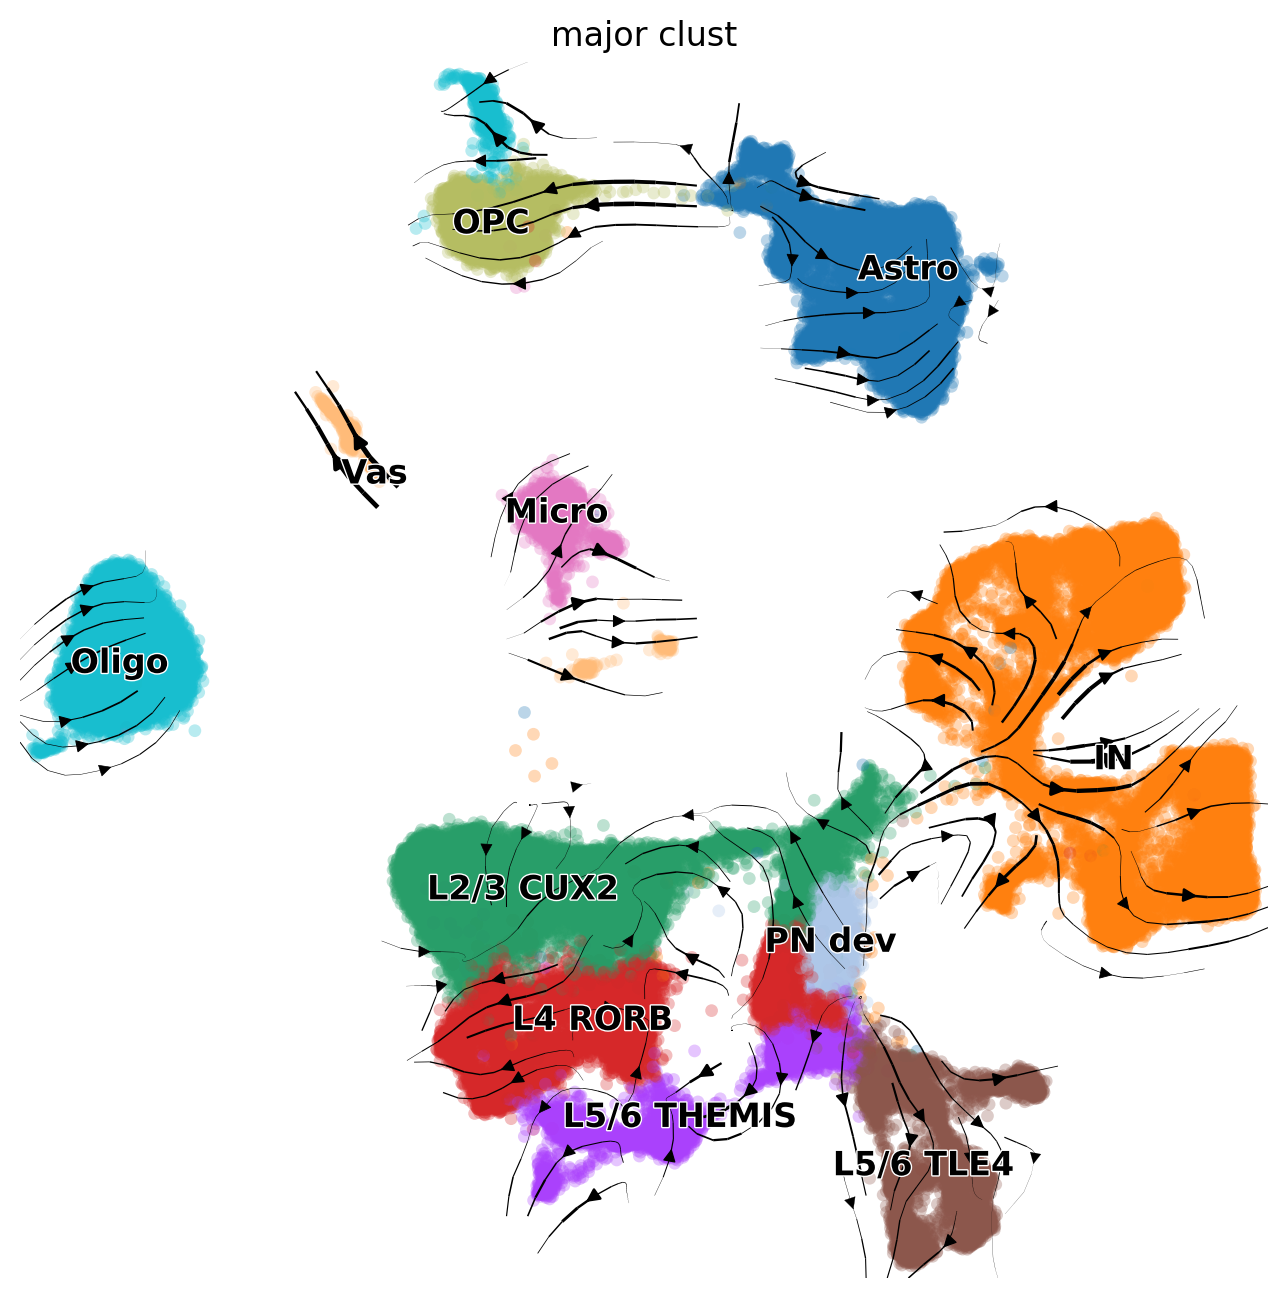

In [45]:
plot_vel( 50, adata=adata, mode='stochastic', basis='umap')

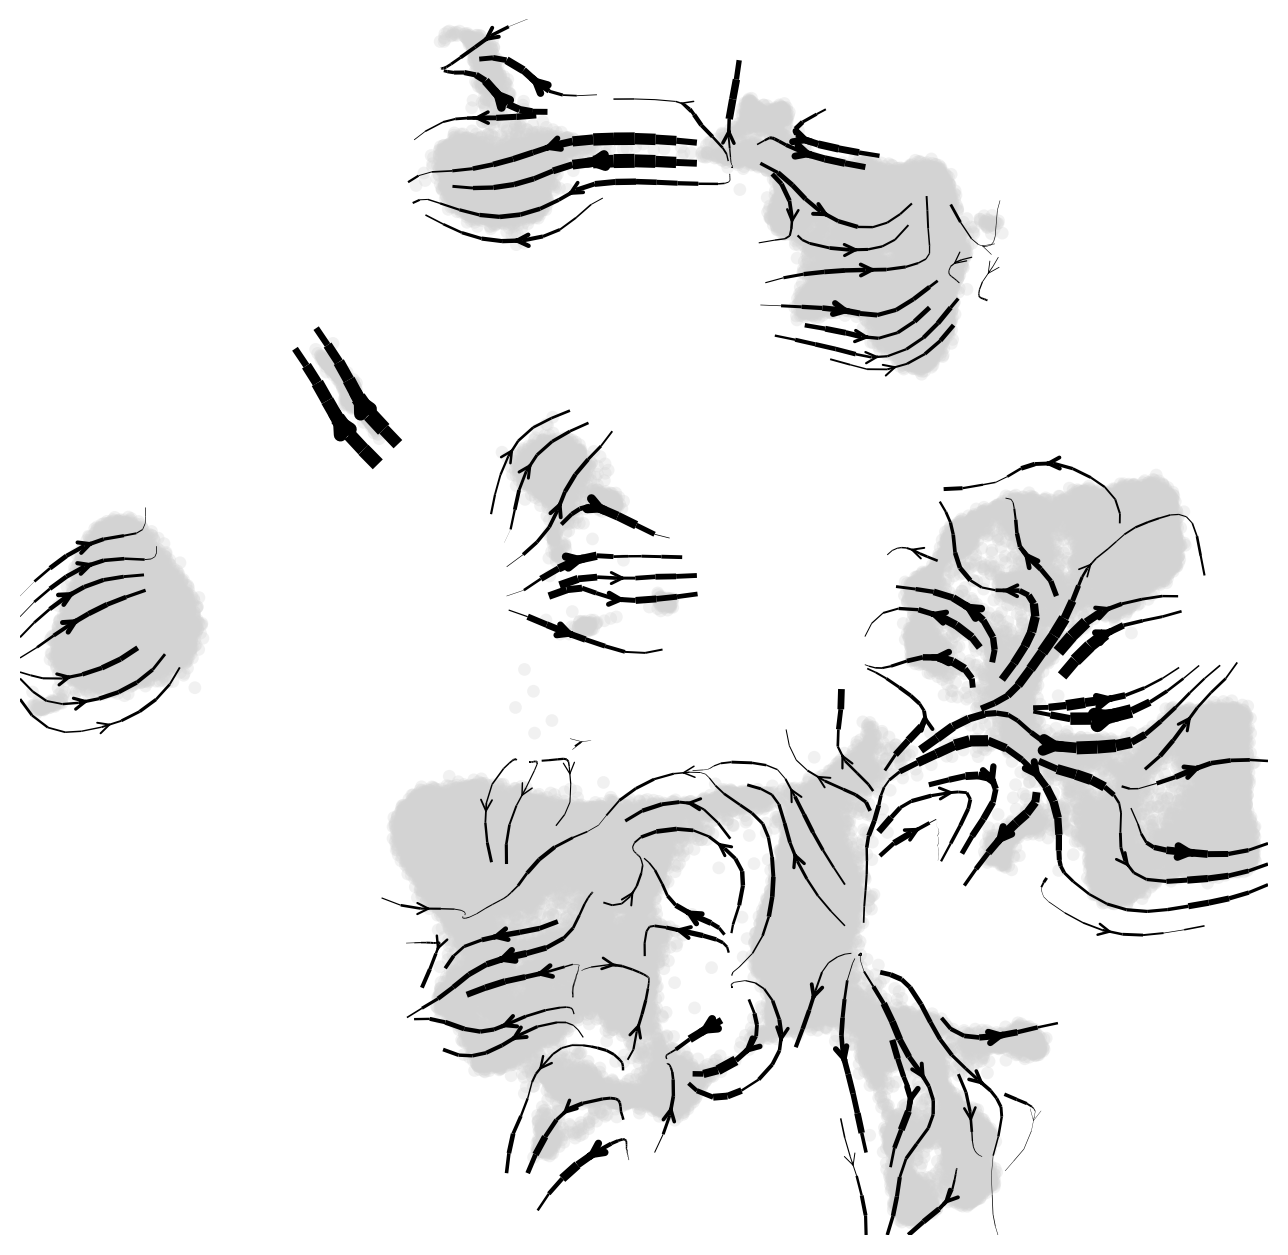

In [46]:
scv.pl.velocity_embedding_stream( adata, color="lightgrey", basis="umap", 
                                      legend_loc='none', figsize=(8,8), cmap='viridis',
                                      linewidth=3.0, arrow_style='->')

## Cellrank - velocity kernel

In [47]:
from cellrank.tl.kernels import VelocityKernel
vk = VelocityKernel( adata).compute_transition_matrix()

  0%|          | 0/121202 [00:00<?, ?cell/s]

  0%|          | 0/121202 [00:00<?, ?cell/s]

In [48]:
vk.compute_projection( basis="umap")

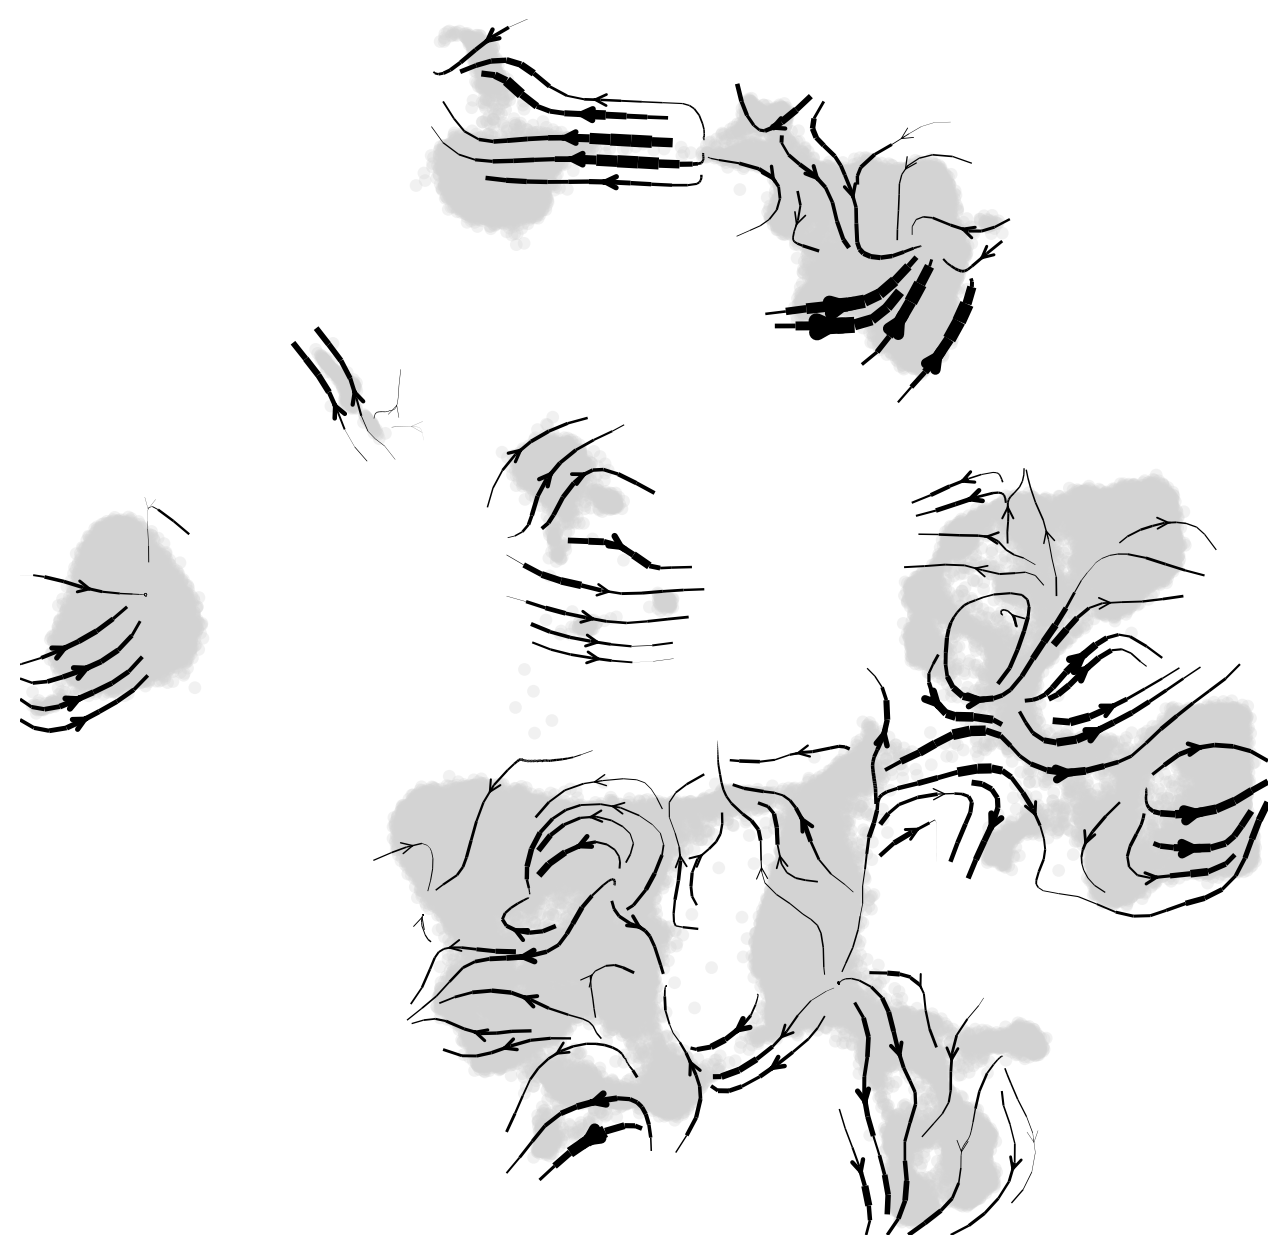

In [49]:
plot_kernel( adata)

## Combine all cellrank kernels

In [63]:
# combined_kernel = 0.333*vk + 0.333*cnk + 0.333*ctk
combined_kernel = 0.5*cnk + 0.5*ctk

In [64]:
print( combined_kernel)

((0.5 * <ConnectivityKernel[dnorm=True, key=connectivities]>) + (0.5 * <CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>))


In [65]:
combined_kernel.compute_transition_matrix()

((0.5 * <ConnectivityKernel>) + (0.5 * <CytoTRACEKernel>))

In [66]:
combined_kernel.compute_projection( basis="umap")

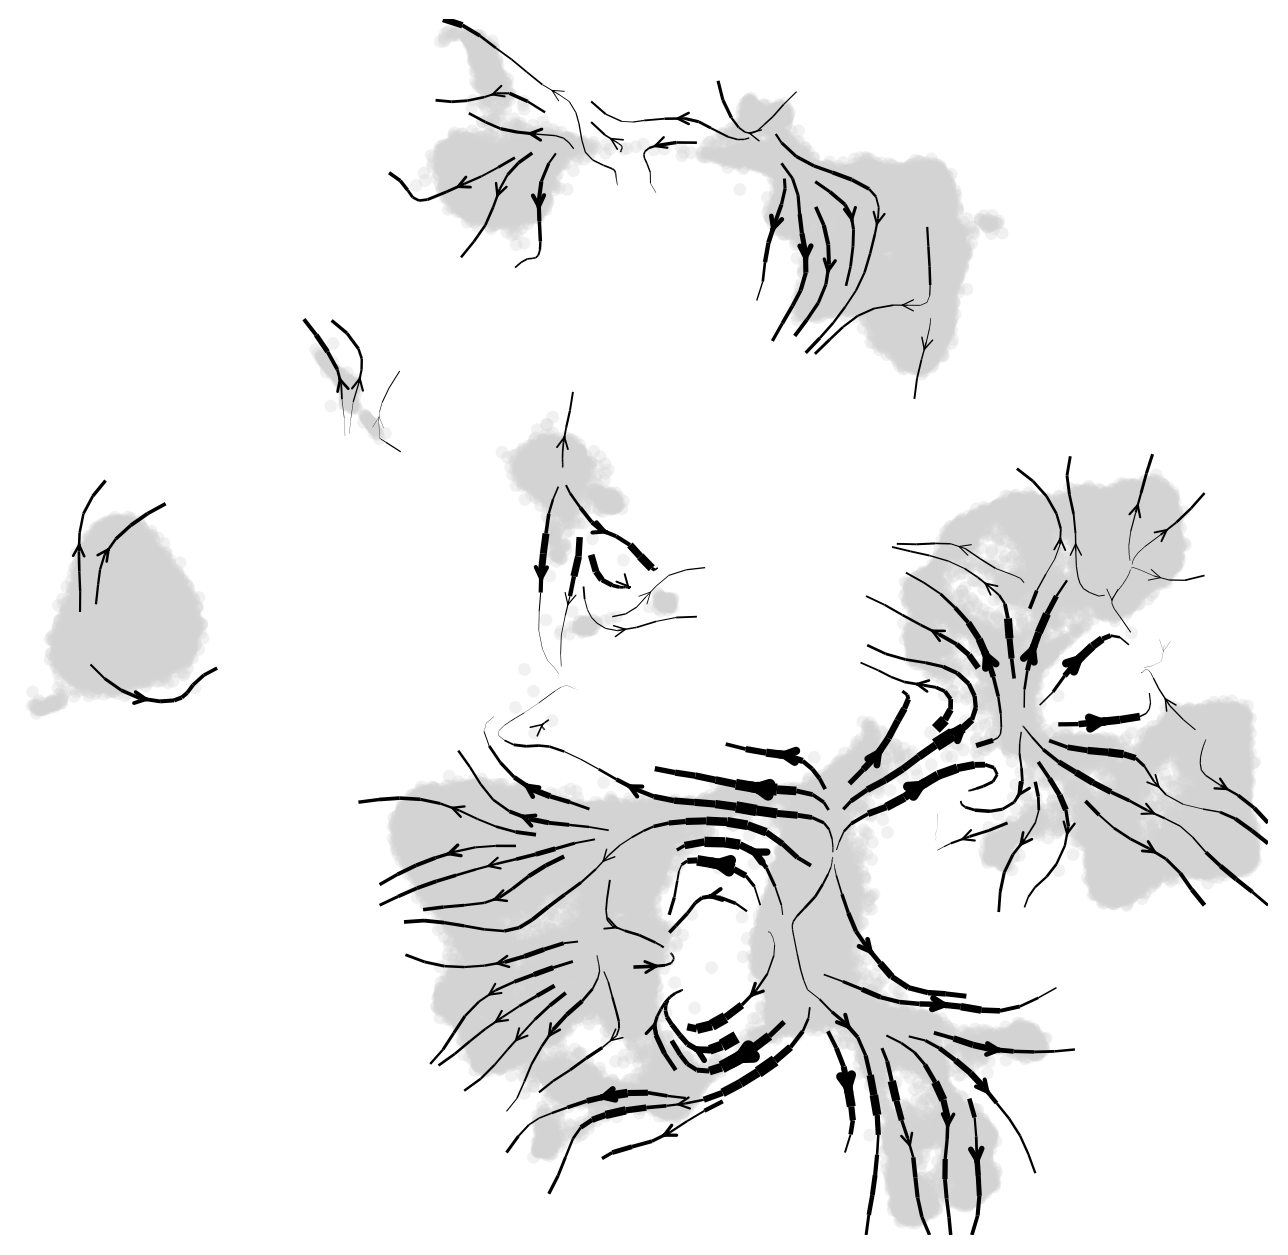

In [67]:
plot_kernel( adata)

In [ ]:
# ax = combined_kernel.plot_single_flow(
#     cluster_key="sub_clust",
#     time_key="stage_num",
#     cluster="MGE_dev",
#     min_flow=0.15,
#     xticks_step_size=1,
#     show=False,
#     dpi=100,
#     clusters=["LAMP5_NOS1", "LAMP5_CCK"],
# )

# # prettify the plot a bit, rotate x-axis tick labels
# locs, labels = plt.xticks()
# ax.set_xticks(locs)
# ax.set_xticklabels(stage_order, rotation=90);

In [ ]:
# ax = combined_kernel.plot_single_flow(
#     cluster_key="sub_clust",
#     time_key="stage_num",
#     cluster="CGE_dev",
#     min_flow=0.15,
#     xticks_step_size=1,
#     show=False,
#     dpi=100,
#     clusters=["LAMP5_NOS1", "LAMP5_CCK"]
# )

# # prettify the plot a bit, rotate x-axis tick labels
# locs, labels = plt.xticks()
# ax.set_xticks(locs)
# ax.set_xticklabels(stage_order, rotation=90);

### Estimate fate probabilities

In [60]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[n=121202, kernel=((0.33 * <VelocityKernel[softmax_scale=17.01, mode=deterministic, seed=9043, scheme=<CorrelationScheme>]>) + (0.33 * <ConnectivityKernel[dnorm=True, key=connectivities]>) + (0.33 * <CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>))]


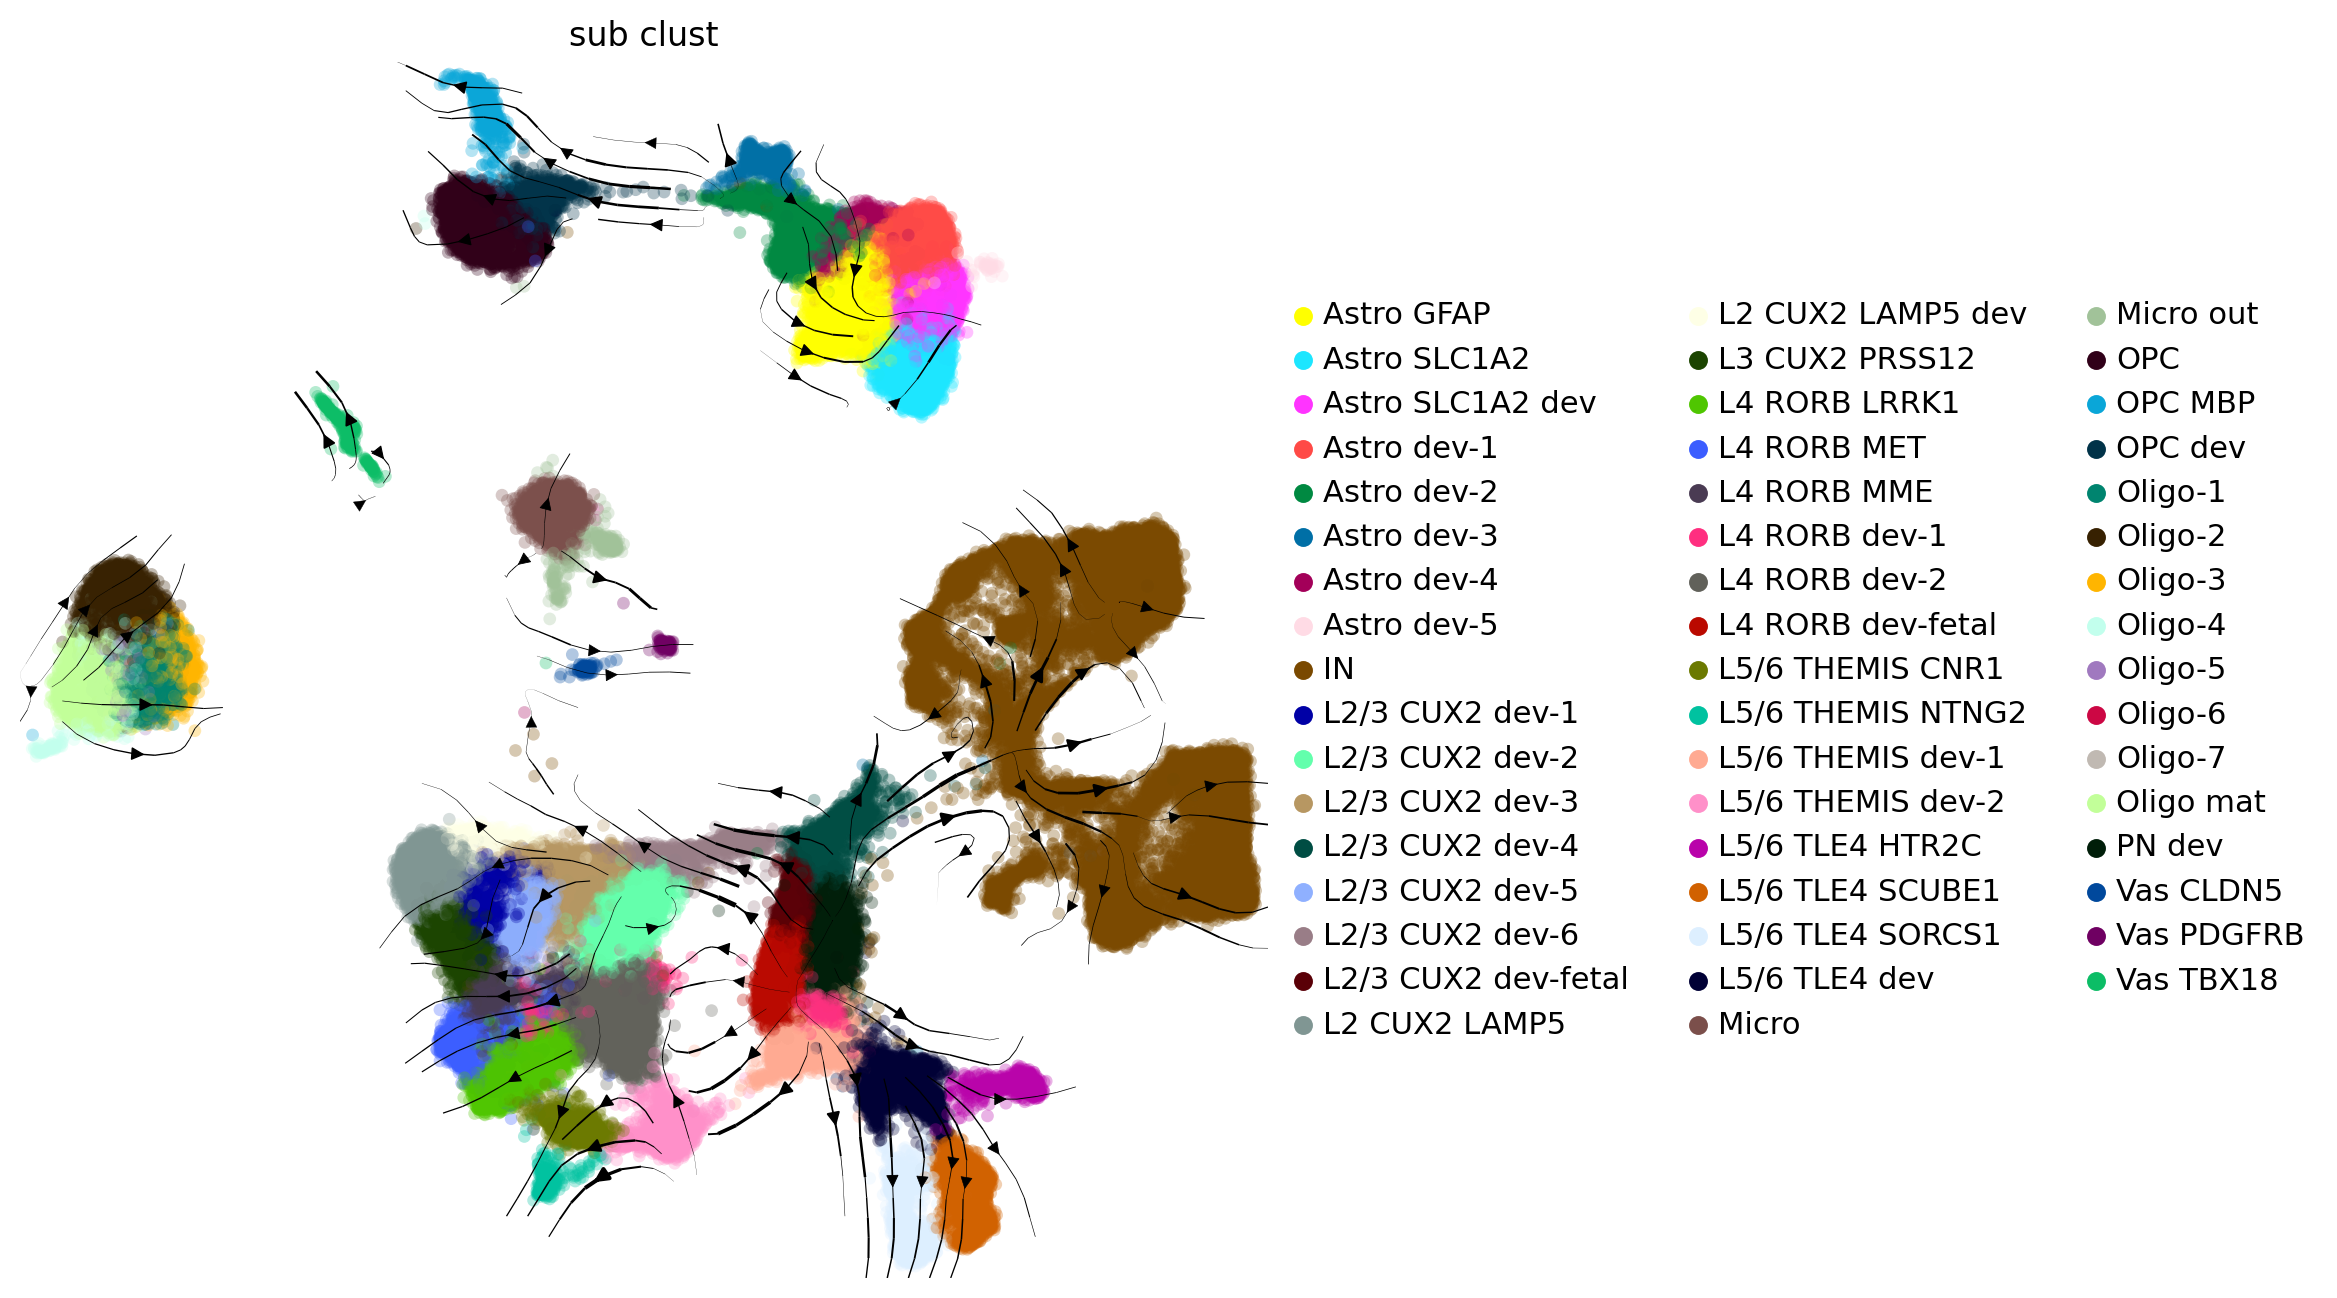

In [61]:
scv.pl.velocity_embedding_stream( adata, color="sub_clust", vkey="T_fwd", basis="umap", legend_loc="right", figsize=(8,8))

In [ ]:
# have to buid dict of terminal states
terms = ['CCK_RELN', 'CCK_SORCS1', 'ID2_CSMD1','LAMP5_NOS1', 
         'LAMP5_CCK', 'LAMP5_NDNF', 'PV_SCUBE3', 'PV_SULF1', 'PV_WFDC2']
term_dict = {}
for tt in terms:
    term_dict[tt] = adata.obs_names[adata.obs['sub_clust']==tt].values

In [62]:
g.compute_macrostates( n_states=50, cluster_key='sub_clust')

MemoryError: Unable to allocate 109. GiB for an array with shape (121202, 121202) and data type float64

In [ ]:
g.plot_macrostates( same_plot=True, basis='umat')

In [ ]:
g.set_terminal_states( labels=term_dict, cluster_key='sub_clust')

In [ ]:
# g.compute_terminal_states()

In [ ]:
g.compute_absorption_probabilities()

In [ ]:
NOS1_drivers = g.compute_lineage_drivers( lineages="LAMP5_NOS1", return_drivers=True)
# alpha_drivers.sort_values(by="LAMP5_NOS1", ascending=False)

In [ ]:
NOS1_drivers.head(10)

In [ ]:
NOS1_drivers.index.values[:10]

In [ ]:
lcp_drivers = g.compute_lineage_drivers( lineages="LAMP5_CCK", return_drivers=True)
# alpha_drivers.sort_values(by="LAMP5_CCK", ascending=False)

In [ ]:
lcp_drivers.head(10)

In [ ]:
lcp_drivers.index.values[:10]

In [ ]:
import cellrank as cr
# cr.pl.lineage_drivers( adata, lineage="LAMP5_NOS1", n_genes=3)

In [ ]:
cr.pl.log_odds( adata, 'LAMP5_NOS1', lineage_2='LAMP5_CCK', time_key='stage_num')

In [ ]:
cr.pl.cluster_fates( adata, cluster_key='sub_clust', mode="bar", clusters=['MGE_dev','CGE_dev'], lineages=['LAMP5_NOS1', 'LAMP5_CCK', 'LAMP5_NDNF'])